# Groupe 3 - Projet Santé 

Dataset: http://medicaldecathlon.com/

### Imports and installs

In [ ]:
pip install nibabel

In [ ]:
pip install celluloid

In [1]:
%matplotlib notebook
from pathlib import Path # To use paths easily
import nibabel as nib # To use NIfTI files
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera # For the volume visualization
from tqdm.notebook import tqdm # For progressing bars
import cv2 # To resize the data
import os, gzip, shutil

## Dataset inspection

We extract all the files from the dataset (.nii.gz to .nii)

In [2]:
dir_name = '/Users/mathildeoukaci/Desktop/EFREI/COURS/S9/PROJETSANTE/data/Task06_Lung/imagesTr/'

def gz_extract(directory):
    extension = ".gz"
    os.chdir(directory)
    for item in os.listdir(directory): # loop through items in dir
        if item.endswith(extension): # check for ".gz" extension
            gz_name = os.path.abspath(item) # get full path of files
            file_name = (os.path.basename(gz_name)).rsplit('.',1)[0] #get file name for file within
            with gzip.open(gz_name,"rb") as f_in, open(file_name,"wb") as f_out:
                  shutil.copyfileobj(f_in, f_out)
            os.remove(gz_name) # delete zipped file
        
gz_extract(dir_name)

In [3]:
dir_name = '/Users/mathildeoukaci/Desktop/EFREI/COURS/S9/PROJETSANTE/data/Task06_Lung/imagesTs/'

def gz_extract(directory):
    extension = ".gz"
    os.chdir(directory)
    for item in os.listdir(directory): # loop through items in dir
        if item.endswith(extension): # check for ".gz" extension
            gz_name = os.path.abspath(item) # get full path of files
            file_name = (os.path.basename(gz_name)).rsplit('.',1)[0] #get file name for file within
            with gzip.open(gz_name,"rb") as f_in, open(file_name,"wb") as f_out:
                  shutil.copyfileobj(f_in, f_out)
            os.remove(gz_name) # delete zipped file
        
gz_extract(dir_name)

In [4]:
dir_name = '/Users/mathildeoukaci/Desktop/EFREI/COURS/S9/PROJETSANTE/data/Task06_Lung/labelsTr/'

def gz_extract(directory):
    extension = ".gz"
    os.chdir(directory)
    for item in os.listdir(directory): # loop through items in dir
        if item.endswith(extension): # check for ".gz" extension
            gz_name = os.path.abspath(item) # get full path of files
            file_name = (os.path.basename(gz_name)).rsplit('.',1)[0] #get file name for file within
            with gzip.open(gz_name,"rb") as f_in, open(file_name,"wb") as f_out:
                  shutil.copyfileobj(f_in, f_out)
            os.remove(gz_name) # delete zipped file
        
gz_extract(dir_name)

In [5]:
# The working directory path has been changed with the gz_extract function.
# Here we set the right working directory by going back three level up in the path.
workdir = '../../..'
os.chdir(workdir)

We define the paths to images and labels

In [6]:
root = Path("./data/Task06_Lung/imagesTr/")
label = Path("./data/Task06_Lung/labelsTr/")

We need to associate the imagesTr path with its corresponding labelsTr path

In [7]:
def change_img_to_label_path(path):
    parts = list(path.parts)  # get all directories that are in the path
    parts[parts.index("imagesTr")] = "labelsTr"  # Associate imagesTr with labelsTr
    return Path(*parts)

In [8]:
sample_path = list(root.glob("lung*"))[2]  # Choose a subject
sample_path_label = change_img_to_label_path(sample_path)

In [9]:
# Let's check if it worked
sample_path, sample_path_label

(PosixPath('data/Task06_Lung/imagesTr/lung_033.nii'),
 PosixPath('data/Task06_Lung/labelsTr/lung_033.nii'))

Now we can load the NIfTI file and extract image data

In [10]:
data = nib.load(sample_path)
label = nib.load(sample_path_label)

ct = data.get_fdata()
mask = label.get_fdata()

And plot the figure

In [ ]:
fig = plt.figure()
camera = Camera(fig)  # create the camera object from celluloid

for i in range(0, ct.shape[2], 2):  # axial view
    plt.imshow(ct[:,:,i], cmap="bone")
    mask_ = np.ma.masked_where(mask[:,:,i]==0, mask[:,:,i])
    plt.imshow(mask_, alpha=0.5, cmap="autumn")
    #plt.axis("off")
    camera.snap()  # Store the current slice
animation = camera.animate()  # create the animation


## Preprocessing 

In [12]:
all_files = list(root.glob("lung_*"))  # Get all subjects
len(all_files)

63

#### In this preprocessing part, we will:
    
    - Normalize the range of the CT images. 
    CT images have a range from -1000 to 3071 so we will normalize it by dividing by 3071.

    - Crop parts of the lower abdomen to reduce the complexity.
    We want to focus on the lung so we can crop parts of the lower abdomen.
    
    - Store the data as 2D files for faster loading.
    
    - Resize the slices and masks to (256,256)

In [13]:
save_root = Path("Task06_Lung/Preprocessed")

for counter, path_to_ct_data in enumerate(tqdm(all_files)):
        
    path_to_label = change_img_to_label_path(path_to_ct_data)  # Get path to ground truth
    
    # Load and extract corresponding data
    ct_data = nib.load(path_to_ct_data).get_fdata()
    label_data = nib.load(path_to_label).get_fdata()
    
    # Crop volume and label.
    # We remove the first 30 slices.
    ct_data = ct_data[:,:,30:] / 3071
    label_data = label_data[:,:,30:]
        
    # Check if train or val data and create corresponding path
    if counter < 57:
        current_path = save_root/"train"/str(counter)
    else:
        current_path = save_root/"val"/str(counter)
    
    # Loop over the slices in the full volume and store the data and labels in the data/masks directory
    for i in range(ct_data.shape[-1]):
        slice = ct_data[:,:,i]
        mask = label_data[:,:,i]
        
        # Resize slice and label to common resolution to reduce training time
        slice = cv2.resize(slice, (256, 256))
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
        
        slice_path = current_path/"data"
        mask_path = current_path/"masks"
        slice_path.mkdir(parents=True, exist_ok=True)
        mask_path.mkdir(parents=True, exist_ok=True)
        
        np.save(slice_path/str(i), slice)
        np.save(mask_path/str(i), mask)
        
        
    

  0%|          | 0/63 [00:00<?, ?it/s]

We can check if it worked

In [15]:
path = Path("Task06_Lung/Preprocessed/train/2")  # Select a subject. Check the folder if it exists

In [16]:
list(path.glob("*"))

[PosixPath('Task06_Lung/Preprocessed/train/2/data'),
 PosixPath('Task06_Lung/Preprocessed/train/2/masks')]

In [21]:
# Choose a file and load the slice and mask
file = "120.npy"
slice = np.load(path/"data"/file)
mask = np.load(path/"masks"/file)

<IPython.core.display.Javascript object>


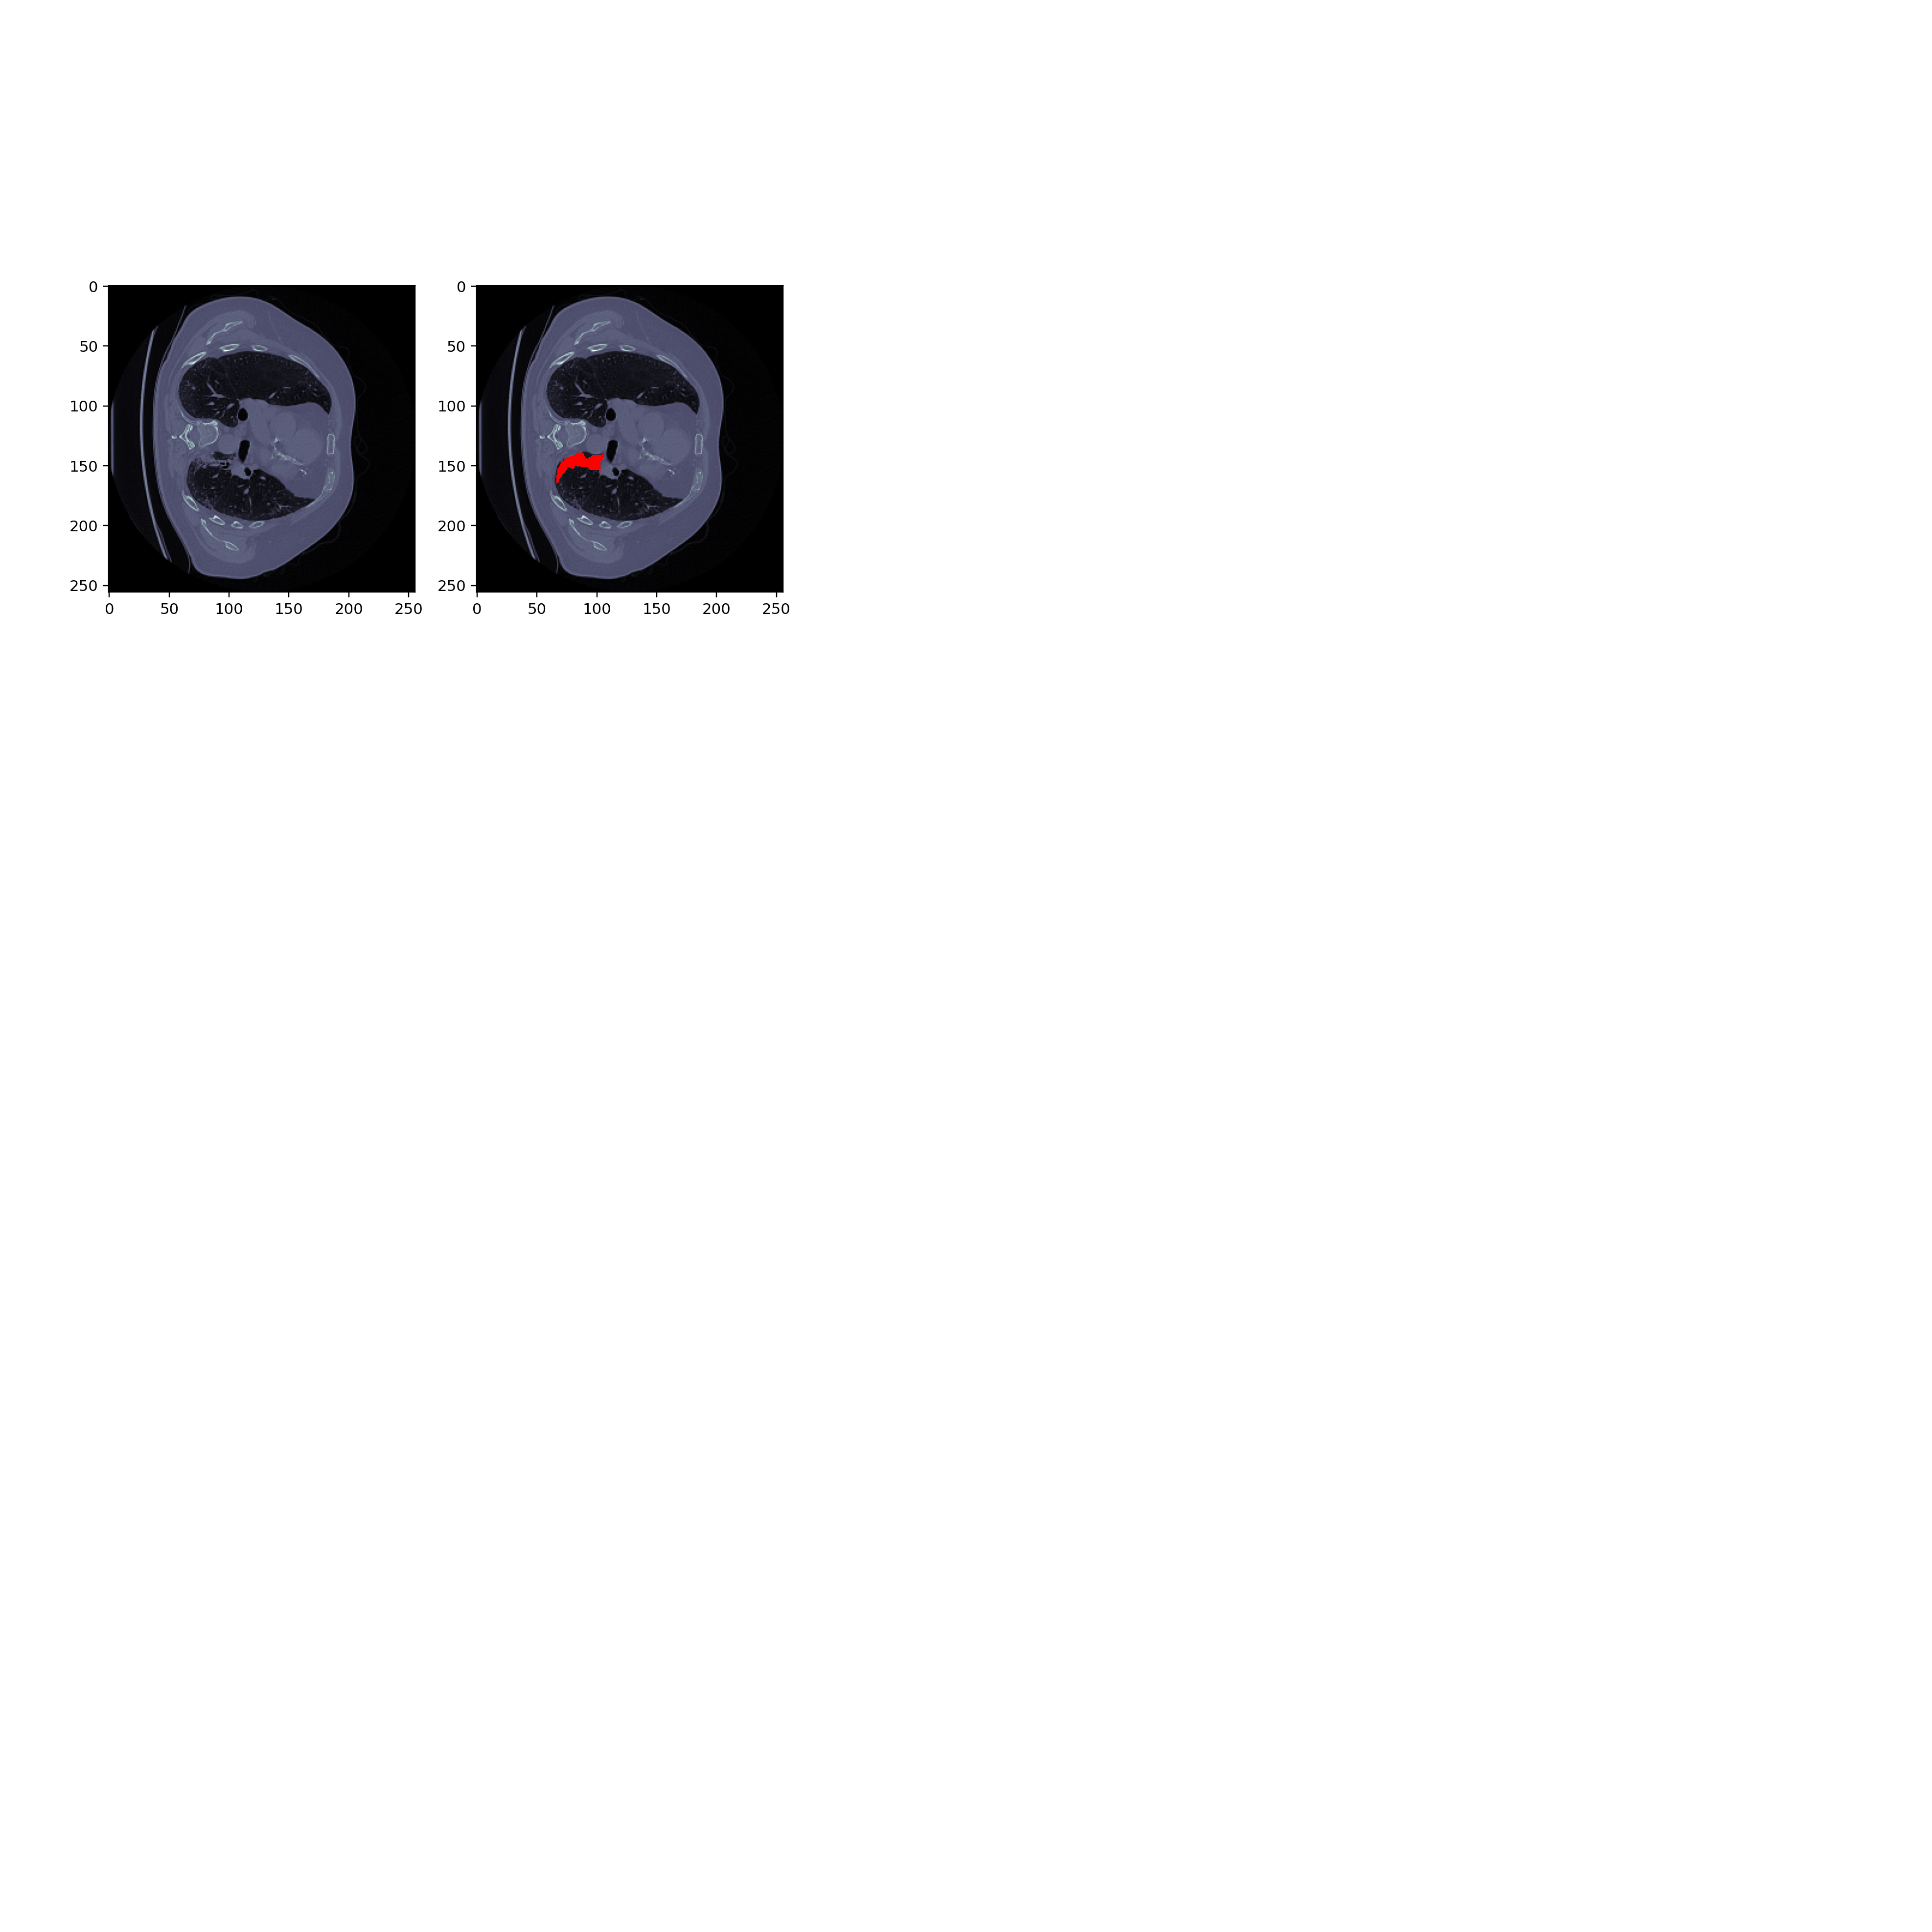

In [20]:
# Plot everything
fig, axis = plt.subplots(1, 2, figsize=(8, 8))
axis[0].imshow(slice, cmap="bone")
mask_ = np.ma.masked_where(mask==0, mask)
axis[1].imshow(slice, cmap="bone")
axis[1].imshow(mask_, cmap="autumn")

In [22]:
print(slice.min(), slice.max())

-0.33344187561055033 0.5288993813090198
